# Planetoid

In Chapter 4 and 5 we have presented Planetoid.

Planetoid is a framework designed for *semi-supervised learning* on graphs, particularly useful when only a small portion of the graph nodes are labeled. It is applied to problems where we have a graph-structured dataset, such as citation networks, social networks, or knowledge graphs.

The key idea behind Planetoid is to learn node embeddings that are able to capture both graph structure and label information. Planetoid achieves this by combining a supervised loss (for labeled nodes) and an unsupervised loss (for the graph structure, inferred from the edges), leading to more accurate predictions for the unlabeled nodes. Specifically, it uses random walks to capture the local graph structure and applies a Skip-gram model (similar to Word2Vec) to learn node embeddings, while also incorporating label information to improve performance.

Key Characteristics of Planetoid:
- Semi-supervised: Combines labeled and unlabeled data to improve the model.
- Graph-based: Uses graph structure information to learn the relationships between nodes.
- Random Walks & Skip-gram: Uses random walks on the graph to capture the local structure and applies a Skip-gram model to learn embeddings.

Planetoid comes in two version, a _transductive_ and an _inductive_ one, namely *Planetoid-T* and *Planetoid-I*

The original implementation can be found at [this repo](https://github.com/kimiyoung/planetoid). However, it uses quite old frameworks such as Lasagne and theano. For this reason, we have provided a sample implementation below.

_Important Note: since this is a custom implementation, results may be different from the original paper. However, it should be close enugh to capture the theoretical concept_

In [1]:
# adapted from https://github.com/kimiyoung/planetoid

#### Planetoid-T: A Transductive Approach to Semi-Supervised Learning
Planetoid-T (Transductive Planetoid) is an extension of the original Planetoid framework. While Planetoid is primarily inductive (learning embeddings that generalize to unseen nodes), Planetoid-T specifically focuses on a transductive setting, where all nodes (both labeled and unlabeled) are known during training, and the model uses this to learn embeddings for all nodes in the graph.

In Planetoid-T, the model learns node embeddings in a way that explicitly incorporates both labeled information and graph structure by utilizing two types of losses:

1. Supervised Loss: This is based on the labeled nodes, encouraging the model to predict the correct label for these nodes.
2. Unsupervised Loss: This loss captures the graph structure by predicting node pairs based on their proximity in the graph.

The architecture used in Planetoid-T is typically a multi-layer feed-forward neural network where embeddings for nodes are refined during training. It combines the benefits of label propagation (through graph structure) and deep learning (through neural networks), making it an effective approach for large-scale semi-supervised learning tasks on graph-structured data.

_importat note: The implementation below may require a lot of time. However its easier to follow from a didactic point of view. To speed up the process, we have provided a faster implementation using sparse tensors in the next cell_

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import subgraph

from tqdm import tqdm

# Load Cora dataset
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]  # Graph object

###########################################
# Computing embeddings and training may require a lot of time.
# You may want to subsample the graph for didactic purposes.
# Do it here.
###########################################

features = data.x  # Node features
labels = data.y  # Node labels
adj_matrix = to_dense_adj(data.edge_index)[0]  # Dense adjacency matrix
num_nodes, feature_dim = features.shape
num_classes = dataset.num_classes

# Parameters
hidden_dim = 64
embedding_dim = 64
learning_rate = 0.01
lambda_weight = 0.5  # Weight for unsupervised loss
pretrain_epochs = 100
train_epochs = 200
neg_sample_ratio = 1.0  # Ratio of negative samples to positive samples
random_walk_length = 10
window_size = 5

# Random Walk Sampling
def random_walk_sampling(adj_matrix, num_walks=10, walk_length=10):
    """Generates random walk sequences."""
    walks = []
    for node in range(num_nodes):
        for _ in range(num_walks):
            walk = [node]
            for _ in range(walk_length - 1):
                neighbors = torch.nonzero(torch.Tensor(adj_matrix[node]), as_tuple=True)[0].tolist()
                if neighbors:
                    walk.append(np.random.choice(neighbors))
                else:
                    break
            walks.append(walk)
    return walks

# Generate positive and negative pairs
def generate_pairs(walks, window_size, neg_sample_ratio):
    """Generates positive and negative samples for context prediction."""
    pairs = []
    for walk in tqdm(walks):
        for i, node in enumerate(walk):
            # Positive pairs within the sliding window
            for j in range(max(0, i - window_size), min(len(walk), i + window_size + 1)):
                if i != j:
                    pairs.append((node, walk[j], 1))  # Positive pair
            # Negative pairs (corrupted context)
            for _ in range(int(neg_sample_ratio)):
                neg_node = np.random.randint(0, num_nodes)
                pairs.append((node, neg_node, -1))
    return pairs

# Model definition
class PlanetoidT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, embedding_dim):
        super(PlanetoidT, self).__init__()
        # Feature-based layers
        self.feature_nn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        # Embedding-based layers
        self.embedding_nn = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        # Parameters for embeddings
        self.embeddings = nn.Parameter(torch.randn(num_nodes, embedding_dim))
        # Classifier
        self.classifier = nn.Linear(2 * output_dim, num_classes)

    def forward(self, x):
        h_feature = self.feature_nn(x)
        h_embedding = self.embedding_nn(self.embeddings)
        combined = torch.cat([h_feature, h_embedding], dim=1)
        return self.classifier(combined)

# Loss functions
def supervised_loss(predictions, labels, mask):
    """Cross-entropy loss for labeled nodes."""
    return F.cross_entropy(predictions[mask], labels[mask])

def unsupervised_loss(pairs, embeddings):
    """Negative sampling-based loss for graph context prediction."""
    loss = 0
    for ith, (i, c, label) in enumerate(tqdm(pairs)):
        score = torch.dot(embeddings[i], embeddings[c])
        old_loss = float(loss)
        if label == 1:
            loss += -torch.log(torch.sigmoid(score))
        else:
            loss += -torch.log(1 - torch.sigmoid(score))
        if torch.isnan(loss) or torch.isinf(loss):
            print(loss)
            print(torch.log(torch.sigmoid(score)))
            print(old_loss)
            print(score)
            print(label)
            raise ValueError()
    return loss / len(pairs)

##### Faster implementation of Planetoid-T

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from torch_sparse import SparseTensor
import numpy as np

# Load Cora dataset
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]
features = data.x
labels = data.y
adj_matrix = to_dense_adj(data.edge_index)[0]
num_nodes, feature_dim = features.shape
num_classes = dataset.num_classes

# Parameters
hidden_dim = 64
embedding_dim = 64
learning_rate = 0.01
lambda_weight = 0.5
pretrain_epochs = 50
train_epochs = 100
neg_sample_ratio = 1.0

# Convert adjacency to sparse tensor
adj_sparse = SparseTensor.from_dense(adj_matrix)

# Efficient random walk sampling
def efficient_sample_context(adj, num_samples=10, neg_ratio=1.0):
    """Sample positive and negative context pairs efficiently."""
    row, col, _ = adj.coo()  # Edge list
    num_edges = row.size(0)

    # Sample positive pairs
    idx = torch.randint(0, num_edges, (num_samples,))
    pos_pairs = torch.stack((row[idx], col[idx]), dim=1)

    # Sample negative pairs
    neg_pairs = []
    for _ in range(int(num_samples * neg_ratio)):
        neg_src = torch.randint(0, num_nodes, (num_samples,))
        neg_dst = torch.randint(0, num_nodes, (num_samples,))
        neg_pairs.append(torch.stack((neg_src, neg_dst), dim=1))
    neg_pairs = torch.cat(neg_pairs, dim=0)

    # Combine and return
    labels = torch.cat([torch.ones(pos_pairs.size(0)), -torch.ones(neg_pairs.size(0))])
    return torch.cat([pos_pairs, neg_pairs], dim=0), labels

# Model definition
class PlanetoidT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, embedding_dim):
        super(PlanetoidT, self).__init__()
        self.feature_nn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        self.embedding_nn = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        self.embeddings = nn.Parameter(torch.randn(num_nodes, embedding_dim))
        self.classifier = nn.Linear(2 * output_dim, num_classes)

    def forward(self, x):
        h_feature = self.feature_nn(x)
        h_embedding = self.embedding_nn(self.embeddings)
        combined = torch.cat([h_feature, h_embedding], dim=1)
        return self.classifier(combined)

# Loss functions
def supervised_loss(predictions, labels, mask):
    return F.cross_entropy(predictions[mask], labels[mask])

def unsupervised_loss(context_pairs, labels, embeddings):
    src, dst = context_pairs[:, 0], context_pairs[:, 1]
    scores = (embeddings[src] * embeddings[dst]).sum(dim=1)
    return F.binary_cross_entropy_with_logits(scores, (labels + 1) / 2)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PlanetoidT(input_dim=feature_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, embedding_dim=embedding_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

features, labels = features.to(device), labels.to(device)
train_mask = data.train_mask.to(device)
test_mask = data.test_mask.to(device)

# Pretraining embeddings
print("Pretraining embeddings...")
for epoch in range(pretrain_epochs):
    optimizer.zero_grad()
    context_pairs, labels_context = efficient_sample_context(adj_sparse, num_samples=1000, neg_ratio=neg_sample_ratio)
    context_pairs, labels_context = context_pairs.to(device), labels_context.to(device)
    loss = unsupervised_loss(context_pairs, labels_context, model.embeddings)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Pretraining Epoch {epoch:03d}, Loss: {loss.item():.4f}")

# Joint training
print("Joint training...")
for epoch in range(train_epochs):
    model.train()
    optimizer.zero_grad()

    # Supervised loss
    predictions = model(features)
    Ls = supervised_loss(predictions, labels, train_mask)

    # Unsupervised loss
    context_pairs, labels_context = efficient_sample_context(adj_sparse, num_samples=1000, neg_ratio=neg_sample_ratio)
    context_pairs, labels_context = context_pairs.to(device), labels_context.to(device)
    Lu = unsupervised_loss(context_pairs, labels_context, model.embeddings)

    # Combined loss
    loss = Ls + lambda_weight * Lu
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Ls: {Ls.item():.4f}, Lu: {Lu.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(features).argmax(dim=1)
    accuracy = (predictions[test_mask] == labels[test_mask]).float().mean()
    print(f"Test Accuracy: {accuracy:.4f}")

Pretraining embeddings...
Pretraining Epoch 000, Loss: 3.2761
Pretraining Epoch 010, Loss: 2.8495
Pretraining Epoch 020, Loss: 2.4809
Pretraining Epoch 030, Loss: 2.1658
Pretraining Epoch 040, Loss: 1.9020
Joint training...
Epoch 000, Loss: 2.7846, Ls: 1.9508, Lu: 1.6677
Epoch 010, Loss: 0.7608, Ls: 0.0014, Lu: 1.5189
Epoch 020, Loss: 0.7075, Ls: 0.0000, Lu: 1.4151
Epoch 030, Loss: 0.6647, Ls: 0.0000, Lu: 1.3294
Epoch 040, Loss: 0.6297, Ls: 0.0000, Lu: 1.2595
Epoch 050, Loss: 0.5959, Ls: 0.0000, Lu: 1.1917
Epoch 060, Loss: 0.5666, Ls: 0.0000, Lu: 1.1331
Epoch 070, Loss: 0.5413, Ls: 0.0000, Lu: 1.0826
Epoch 080, Loss: 0.5166, Ls: 0.0000, Lu: 1.0333
Epoch 090, Loss: 0.4965, Ls: 0.0000, Lu: 0.9931
Test Accuracy: 0.4490


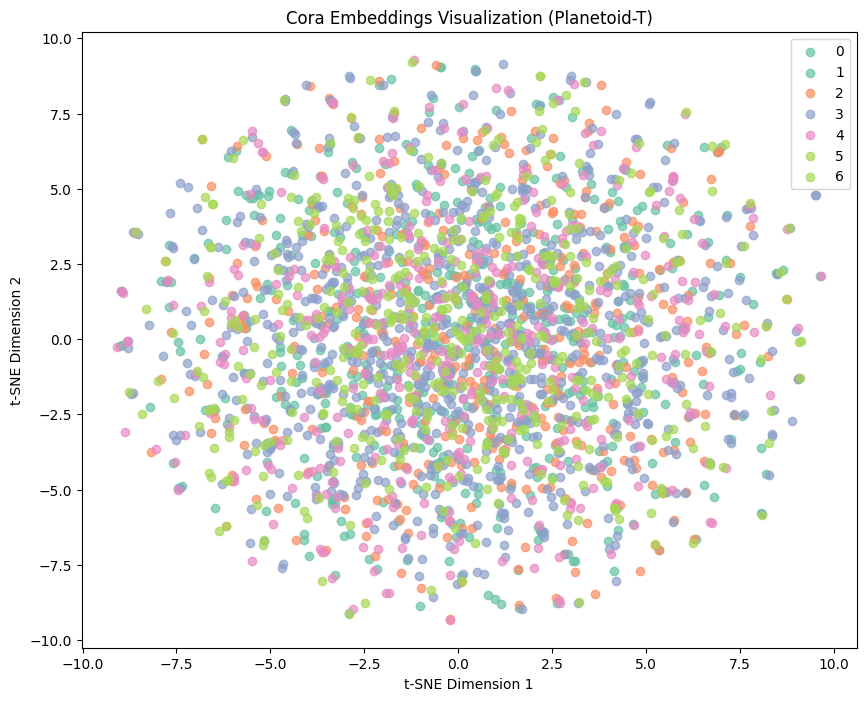

In [4]:
from matplotlib import colors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm

def visualize_embeddings(embeddings, labels, title="Embeddings Visualization"):
    """
    Visualize the embeddings in 2D using t-SNE.
    :param embeddings: The node embeddings (tensor of shape [num_nodes, embedding_dim]).
    :param labels: The ground truth labels for the nodes.
    :param title: Title for the plot.
    """
    # Reduce embeddings to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_embeddings = tsne.fit_transform(embeddings.cpu().detach().numpy())

    plt.figure(figsize=(10, 8))

    norm = colors.Normalize(vmin=0, vmax=10)

    for lab in np.unique(labels):
        idx = np.where(node_labels==lab)

        #colormap possible values = viridis, jet, spectral
        color = colors.to_hex(cm.Set2(norm(lab)))
        plt.scatter(
            x=reduced_embeddings[idx, 0],
            y=reduced_embeddings[idx, 1],
            color=color,
            label=lab,
            alpha=0.7
        )
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend() #title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Extract embeddings and labels
node_embeddings = model.embeddings
node_labels = labels

# Visualize embeddings
visualize_embeddings(node_embeddings, node_labels, title="Cora Embeddings Visualization (Planetoid-T)")

As expected, results differs from the original implementation and more hyperparameter tuning may be needed to achive better results.

#### Planetoid-I: Inductive Learning for Semi-Supervised Graph Learning
While the transductive Planetoid framework is highly effective for scenarios where all nodes, including unlabeled ones, are observed during training, there are situations where we need a model that can generalize to unseen instances. This is especially important in large-scale or dynamic settings where new nodes (e.g., new entities, articles, or documents) continuously emerge, and retraining on the entire graph or dataset becomes impractical.

Planetoid-I (Inductive Planetoid) addresses this challenge by introducing an inductive learning approach for graph embedding and semi-supervised learning. Unlike the transductive setting, where embeddings are learned for all nodes (labeled and unlabeled) simultaneously, Planetoid-I ensures that the learned model can be applied to unseen nodes during inference. This is achieved by designing the embeddings as a parameterized function of the input feature vector.

###### Key Features of Planetoid-I:
- **Inductive Nature**: Embeddings are learned as functions of node features, allowing the model to generalize to new, unseen nodes.
- **Embedding as a Function of Input Features**: Instead of learning a fixed embedding for each node, the embedding is defined as a parameterized function of the node's input feature vector \( x \), making the approach inductive.
- **No Shared Embeddings**: Unlike the transductive approach, Planetoid-I does not use shared embeddings across all nodes but instead computes node embeddings dynamically based on features.

###### Loss Function:
The **Planetoid-I** loss function combines two terms:
1. **Supervised Loss**: The first term encourages correct label prediction for labeled nodes.
   \[
   L_s = -\frac{1}{L} \sum_{i=1}^{L} \log p(y_i | x_i)
   \]
2. **Unsupervised Loss**: The second term uses negative sampling to learn graph structure by predicting the context of nodes.
   \[
   L_u = -\lambda \mathbb{E}_{(i, c, \gamma)} \log \sigma(\gamma w_c^T h_{l1}(x_i))
   \]

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

# Load Cora dataset
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]

# Planetoid-I Model
class PlanetoidIModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(PlanetoidIModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

        # This layer is the inductive part that computes the embedding directly from the features
        self.fc4 = nn.Linear(input_dim, hidden_dim1)

    def forward(self, x):
        # Inductive embeddings as a function of input features
        e = F.relu(self.fc4(x))  # Inductive embedding
        h = F.relu(self.fc1(x))  # First layer
        h = F.relu(self.fc2(h))  # Second layer
        h = self.fc3(h)          # Output layer

        return h, e

# Training function for Planetoid-I
def train_model(model, data, optimizer, criterion, lambda_):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output, e = model(data.x)

    # Supervised loss (cross-entropy)
    supervised_loss = F.cross_entropy(output[data.train_mask], data.y[data.train_mask])

    # Unsupervised loss (negative sampling)
    context_loss = 0
    negative_samples = 10  # Number of negative samples for each context

    # Negative sampling
    for i in range(len(data.x)):
        pos_idx = i
        neg_idx = np.random.randint(0, len(data.x), negative_samples)

        # Negative sampling loss calculation
        context_loss += -torch.log(torch.sigmoid(torch.matmul(e[pos_idx], e[neg_idx].T))).mean()

    # Total loss
    loss = supervised_loss + lambda_ * context_loss
    loss.backward()
    optimizer.step()

    return loss.item()

# Evaluate function for Planetoid-I
def evaluate_model(model, data):
    model.eval()
    output, _ = model(data.x)
    pred = output.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc

# Hyperparameters
input_dim = dataset.num_features
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = dataset.num_classes
lambda_ = 0.1  # Weight for unsupervised loss
learning_rate = 0.01
epochs = 200

# Model, optimizer, and loss function
model = PlanetoidIModel(input_dim, hidden_dim1, hidden_dim2, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

# Training loop
for epoch in range(epochs):
    loss = train_model(model, data, optimizer, F.cross_entropy, lambda_)
    if epoch % 10 == 0:
        acc = evaluate_model(model, data)
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

# Final Evaluation
acc = evaluate_model(model, data)
print(f'Final Test Accuracy: {acc:.4f}')

Epoch 1, Loss: 176.1518, Test Accuracy: 0.3170
Epoch 11, Loss: 0.0145, Test Accuracy: 0.5070
Epoch 21, Loss: 0.0002, Test Accuracy: 0.4400
Epoch 31, Loss: 0.0001, Test Accuracy: 0.4200
Epoch 41, Loss: 0.0001, Test Accuracy: 0.4460
Epoch 51, Loss: 0.0002, Test Accuracy: 0.5030
Epoch 61, Loss: 0.0009, Test Accuracy: 0.5580
Epoch 71, Loss: 0.0018, Test Accuracy: 0.5710
Epoch 81, Loss: 0.0020, Test Accuracy: 0.5700
Epoch 91, Loss: 0.0021, Test Accuracy: 0.5730
Epoch 101, Loss: 0.0021, Test Accuracy: 0.5710
Epoch 111, Loss: 0.0020, Test Accuracy: 0.5730
Epoch 121, Loss: 0.0019, Test Accuracy: 0.5760
Epoch 131, Loss: 0.0019, Test Accuracy: 0.5750
Epoch 141, Loss: 0.0019, Test Accuracy: 0.5680
Epoch 151, Loss: 0.0019, Test Accuracy: 0.5680
Epoch 161, Loss: 0.0018, Test Accuracy: 0.5700
Epoch 171, Loss: 0.0019, Test Accuracy: 0.5730
Epoch 181, Loss: 0.0019, Test Accuracy: 0.5720
Epoch 191, Loss: 0.0019, Test Accuracy: 0.5710
Final Test Accuracy: 0.5710
